In [3]:
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [4]:
import torch.nn as nn
import torch.nn.functional as F
# from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch_geometric.nn import GCNConv

## Define net, training func given batch, and data. 

### Nets

In [5]:
class GCN_SGD(torch.nn.Module):
    def __init__(self, H, nlayers = 2, splus = False):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(2, H))
        if nlayers == 2:
            self.convs.append(GCNConv(H, 1))
        else:
            self.convs.append(GCNConv(H, H))
            self.convs.append(GCNConv(H, 1))
        self.splus = splus

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)
        func = nn.Softplus(beta = 5) if self.splus else F.relu
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = func(x) 
            else:
                x = torch.sigmoid(x)
        return x
    
        
    
class GCN_VI(nn.Module):
    def __init__(self, H, nlayers = 2, splus = False):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(2, H))
        if nlayers == 2:
            self.convs.append(GCNConv(H, 1))
        else:
            self.convs.append(GCNConv(H, H))
            self.convs.append(GCNConv(H, 1))
        self.splus = splus

        #### New lines for SVI ####
        # If any layer true, then it needs to use SVI
        self.layers_with_SVI = [True for i in range(len(self.convs))]
        # Append pre-activation \tilde{X}_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_Xtilde = []
        # Append the grad of L w.r.t. X_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_grad = []
        self.on_training = True
        #### End #####

    #### New lines for SVI ####
    # Avoid gradient accumulation
    def turn_on_off_grad(self, on = True):
        for param in self.parameters():
            param.requires_grad = on
    #### End #####        

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)
        func = nn.Softplus(beta = 5) if self.splus else F.relu
        for i, conv in enumerate(self.convs):
            #### New lines for SVI ####
            # This is added b/c o/w the gradient backprop w.r.t. new loss also gets to earlier layers (undesirable)
            if self.layers_with_SVI[i] and self.on_training:
                x_tmp = x.detach().clone().to(device)
                self.layers_Xtilde.append(conv(x_tmp, edge_index))
            #### End #####
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = func(x)
            else:
                x = torch.sigmoid(x)
            #### New lines for SVI ####
            if self.layers_with_SVI[i] and self.on_training:
                x.retain_grad()  # To get the gradient with respect to output
                self.layers_grad.append(x)
            #### End #####
        return x

def check_layer_grad(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(name, param.grad.norm())

def check_init_norm(model):
    print("#### Initial norm of parameters: ")
    for name, param in model.named_parameters():
        print(name, param.norm())

### For training

In [6]:
cost = nn.MSELoss()

def test(model, data):
    model.eval()
    out = model(data)
    label = data.y.to(device).unsqueeze(1)
    loss = cost(out, label) 
    return loss.item()

def train(model, data):
    model.train()
    # # Uncomment if want to debug
    # check_init_norm(model)
    out = model(data)
    label = data.y.to(device).unsqueeze(1)
    loss = cost(out, label)
    loss.backward()
    # # Uncomment if want to debug
    # print('#### Grad norm of SGD:')
    # check_layer_grad(model)
    # raise Exception("Stop here")
    return loss.item()

def train_SVI(model, data, small_prev_layer = False):
    model.train()
    # # Uncomment if want to debug
    # print(data.x.norm())
    # print(data.y.norm())
    # check_init_norm(model)
    #### New lines for SVI ####
    # NOTE: lines below are necessary, as o/w model.layers_x grow in size as epoches increases
    model.layers_Xtilde = []
    model.layers_grad = []
    model.on_training = True
    #### End #####
    out = model(data)
    label = data.y.to(device).unsqueeze(1)
    loss = cost(out, label) # MSE was \|x\|^2_2
    #### New lines for SVI #### 
    model.turn_on_off_grad(on = False) 
    #### End #####
    loss.backward() # By this time, model parameters should have no gradients
    # # Uncomment if want to debug
    # print(f'#### Grad norm before SVI')
    # check_layer_grad(model)
    #### New lines for SVI ####
    loss_tilde = 0
    k = 0
    for Xlplus1, Xlplus1grad in zip(model.layers_Xtilde, model.layers_grad):
        Xlplus1grad = Xlplus1grad.grad.detach().to(device)
        # This is correct, I have verified it on SVI_old to give the same results
        if small_prev_layer and k < len(model.layers_Xtilde) - 1:
            loss_tilde += (Xlplus1*Xlplus1grad).sum()/Xlplus1.shape[0]
        else:
            loss_tilde += (Xlplus1*Xlplus1grad).sum()/2
        k += 1
    #####
    # ! This is because loss actually w.r.t. graph, NOT node, so need to multiply by # nodes
    num_nodes = int(data.x.shape[0]/data.num_graphs)
    loss_tilde = loss_tilde * num_nodes
    #####
    model.turn_on_off_grad(on = True)
    loss_tilde.backward()  # To get update direction by MVI for all layers at once
    # # Uncomment if want to debug
    # print(f'#### Grad norm after SVI')
    # check_layer_grad(model)
    # raise Exception("Stop here")
    model.on_training = False  # To avoid additional .retain_grad()
    #### End #####
    return loss.item()

In [7]:
# Regenerate data and train
def all_together(random_states, SGD = False, small_prev_layer = True, nlayers = 2):
    results_final_dict = {}
    for random_state in random_states:
        ##### Get data
        n = 40 if graph_type == 'large' else 15
        C = 2
        H_true = 2
        mu = 1
        sigma = 1
        np.random.seed(2)
        W1 = np.random.normal(mu, sigma, H_true*C).reshape((H_true, C)).astype(np.float32)  
        b1 = np.random.normal(mu, sigma, H_true).astype(np.float32)
        W2 = np.random.normal(mu, sigma, H_true).reshape((1, H_true)).astype(np.float32)
        b2 = np.random.normal(mu, sigma, 1).astype(np.float32) 
        W1_more = np.random.normal(mu, sigma, H_true*H_true).reshape((H_true, H_true)).astype(np.float32)
        b1_more = np.random.normal(mu, sigma, H_true).astype(np.float32)
        G = nx.fast_gnp_random_graph(n=n, p=0.15, seed=1103)
        edge_index = torch.tensor(list(G.edges)).T.type(torch.long)
        perturb = 0
        if perturb_edge:
            perturb = 0.2 if graph_type == 'small' else 0.05
        G_est = G_reformat(G, percent_perturb=perturb, return_G=True)
        edge_index = torch.tensor(list(G_est.edges)).T.type(torch.long)
        model_get_data = GCN_SGD(H_true, nlayers).to(device)
        old_dict = model_get_data.state_dict()
        old_dict['convs.0.bias'] = torch.from_numpy(b1).to(device)
        old_dict['convs.0.lin.weight'] = torch.from_numpy(W1).to(device)
        if nlayers > 2:
            old_dict['convs.1.bias'] = torch.from_numpy(b1_more).to(device)
            old_dict['convs.1.lin.weight'] = torch.from_numpy(W1_more).to(device)
            old_dict['convs.2.bias'] = torch.from_numpy(b2).to(device)
            old_dict['convs.2.lin.weight'] = torch.from_numpy(W2).to(device)
        else:
            old_dict['convs.1.bias'] = torch.from_numpy(b2).to(device)
            old_dict['convs.1.lin.weight'] = torch.from_numpy(W2).to(device)
        model_get_data.load_state_dict(old_dict)

        # Data part
        X_train, Y_train = get_simulation_data(
                        model_get_data, N, edge_index, n, C, torch_seed=random_state)
        X_test, Y_test = get_simulation_data(
                        model_get_data, N1, edge_index, n, C, train=False, torch_seed=random_state)
        train_dataloader, test_dataloader = get_train_test_loader(
                        X_train, X_test, Y_train, Y_test, edge_index, batch_size)
        
        ##### Training
        torch.manual_seed(random_state)
        if SGD:
            model = GCN_SGD(H, nlayers, splus).to(device)
        else:
            model = GCN_VI(H, nlayers, splus).to(device)
        train_loss_all, test_loss_all = np.zeros(epochs), np.zeros(epochs)
        pred_l2_train_loss, pred_l2_test_loss = np.zeros(epochs), np.zeros(epochs)
        pred_linf_train_loss, pred_linf_test_loss = np.zeros(epochs), np.zeros(epochs)
        layer_1_norm_all, layer_2_norm_all = np.zeros(epochs), np.zeros(epochs)
        if nlayers > 2:
            layer_3_norm_all = np.zeros(epochs)
        torch.manual_seed(random_state)
        dict_ref = copy.deepcopy(model.state_dict())
        # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
        #                             momentum=momen, nesterov=True)
        for t in range(epochs):
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
                                    momentum=momen, nesterov=True)
            ### Train
            size = len(train_dataloader)
            train_loss = 0
            tot_num = 0
            for data in train_dataloader:
                optimizer.zero_grad()
                if SGD:
                    train_loss += train(model, data) * data.num_graphs
                else:
                    train_loss += train_SVI(model, data, small_prev_layer=small_prev_layer) * data.num_graphs
                tot_num += data.num_graphs
                optimizer.step()
            train_loss /= tot_num
            train_loss_all[t] = train_loss
            # Get prediction error w.r.t. true model
            l2_train_err, linf_train_err = evaluate_lp_err(train_dataloader, model_get_data, model, n)
            pred_l2_train_loss[t] = l2_train_err
            pred_linf_train_loss[t] = linf_train_err

            ### Attach difference in parameter updates
            for name, param in model.named_parameters():
                if '0' in name:
                    layer_1_norm_all[t] += torch.norm(param - dict_ref[name])
                if '1' in name:
                    layer_2_norm_all[t] += torch.norm(param - dict_ref[name])
                if '2' in name:
                    layer_3_norm_all[t] += torch.norm(param - dict_ref[name])

            ### Test
            size = len(test_dataloader)
            test_loss = 0
            tot_num = 0 
            with torch.no_grad():
                model.eval()
                for data in test_dataloader:
                    test_loss += test(model, data) * data.num_graphs
                    tot_num += data.num_graphs
            test_loss /= tot_num
            test_loss_all[t] = test_loss
            # Get prediction error w.r.t. true model
            l2_test_err, linf_test_err = evaluate_lp_err(test_dataloader, model_get_data, model, n)
            pred_l2_test_loss[t] = l2_test_err
            pred_linf_test_loss[t] = linf_test_err
            # if t % 20 == 0:
            #     print(f'Epoch {t}/{epochs}, test linf error = {pred_linf_test_loss[t]:.2e}')

        name = 'SGD' if SGD else 'SVI'
        suffix = ''
        if SGD == False:
            suffix = 'old' if small_prev_layer else 'new'
        print(f'{name} {suffix}, H={H}, random_state={random_state}')
        print(f'training loss = {train_loss_all[t]:.2e}, test loss = {test_loss_all[t]:.2e}')
        print(f'training l2 error = {pred_l2_train_loss[t]:.2e}, test l2 error = {pred_l2_test_loss[t]:.2e}')
        print(f'training linf error = {pred_linf_train_loss[t]:.2e}, test linf error = {pred_linf_test_loss[t]:.2e}')

        results = {'train_loss': train_loss_all, 
                   'test_loss': test_loss_all, 
                   'pred_l2_train_loss': pred_l2_train_loss,
                   'pred_l2_test_loss': pred_l2_test_loss,
                   'pred_linf_train_loss': pred_linf_train_loss,
                   'pred_linf_test_loss': pred_linf_test_loss,
                   'layer_1_norm': layer_1_norm_all,
                   'layer_2_norm': layer_2_norm_all}
        results['model'] = model.state_dict()
        if nlayers > 2:
            results['layer_3_norm'] = layer_3_norm_all
        results_final_dict[random_state] = results
    return results_final_dict, dict_ref, model

### For visualization

In [8]:
def get_ave_results(results_final_dict):
    keys = list(results_final_dict.keys())
    num_rep = len(keys)
    epochs = len(list(results_final_dict.values())[0]['train_loss'])
    ave_results, std_results = {}, {}
    std_suffix = '_std'
    for key in results_final_dict[keys[0]]:
        if key == 'model':
            continue
        ave_results[key] = np.zeros((num_rep, epochs))
        std_results[key+std_suffix] = np.zeros((num_rep, epochs))
    for i, random_state in enumerate(keys):
        for key in results_final_dict[random_state].keys():
            if key == 'model':
                continue
            ave_results[key][i] = results_final_dict[random_state][key]
            std_results[key+std_suffix][i] = results_final_dict[random_state][key]
    for key in ave_results.keys():
        ave_results[key] = np.mean(ave_results[key], axis = 0)
        std_results[key+std_suffix] = np.std(std_results[key+std_suffix], axis = 0)  
    final_dict = {}
    for key in ave_results.keys():
        final_dict[key] = ave_results[key]
        final_dict[key+std_suffix] = std_results[key+std_suffix] 
    return final_dict

In [9]:
def plot_on_axes(train_mean, train_std, test_mean, test_std, args):
    ax = args['ax']
    color = args['color']
    label = args['label']
    ax.plot(train_mean, color = color, label = label + ' train')
    ax.plot(test_mean, color = color, linestyle = '--', label = label + ' test')
    ax.fill_between(range(len(train_mean)), train_mean - train_std, train_mean + train_std, alpha = 0.2, color = color)
    ax.fill_between(range(len(test_mean)), test_mean - test_std, test_mean + test_std, alpha = 0.2, color = color)
    ax.legend()

def plot_on_axes_sub(mean, std, args):
    ax = args['ax']
    color = args['color']
    label = args['label']
    ax.plot(mean, color = color, label = label + ' train')
    ax.fill_between(range(len(mean)), mean - std, mean + std, alpha = 0.2, color = color)
    ax.legend()

In [19]:
def plot_dynamics(a_SGD, w_SGD, a_VI, w_VI, 
                  linferror_ls_SGD, linferror_ls_SVI,
                  mult = 5):
    import matplotlib.gridspec as gridspec
    # Parameters
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    pred_linferror_vanilla_train, pred_linferror_vanilla_trainSE, pred_linferror_vanilla, pred_linferror_vanillaSE = linferror_ls_SGD
    pred_linferror_VI_train, pred_linferror_VI_trainSE, pred_linferror_VI, pred_linferror_VISE = linferror_ls_SVI
    fig = plt.figure(tight_layout=True, figsize=(14, 5))
    gs = gridspec.GridSpec(2, 5)
    cutoff = 2
    ax = fig.add_subplot(gs[:, :cutoff])
    ax.set_xlabel("Epoch", fontsize=16)
    ax.set_ylabel(r"$\ell_{\infty}$ Error", fontsize=20)
    SGD_label = 'SGD'
    xaxis = range(len(pred_linferror_vanilla_train))
    ax.plot(pred_linferror_vanilla_train, linestyle='dashed',
            label=f'{SGD_label} training', color='black')
    ax.fill_between(xaxis, pred_linferror_vanilla_train-pred_linferror_vanilla_trainSE, pred_linferror_vanilla_train+pred_linferror_vanilla_trainSE,
                    color='black', alpha=0.1)
    ax.plot(pred_linferror_vanilla, label=f'{SGD_label} test', color='black')
    ax.fill_between(xaxis, pred_linferror_vanilla-pred_linferror_vanillaSE, pred_linferror_vanilla+pred_linferror_vanillaSE,
                    color='black', alpha=0.1)
    ax.plot(pred_linferror_VI_train, linestyle='dashed', label=f'SVI_small training', color='blue')
    ax.fill_between(xaxis, pred_linferror_VI_train-pred_linferror_VI_trainSE, pred_linferror_VI_train+pred_linferror_VI_trainSE,
                    color='blue', alpha=0.1)
    ax.plot(pred_linferror_VI, label=f'SVI_small test', color='blue')
    ax.fill_between(xaxis, pred_linferror_VI-pred_linferror_VISE, pred_linferror_VI+pred_linferror_VISE,
                    color='blue', alpha=0.1)
    ax.legend(loc='upper right', fontsize=12.5, ncol=1)
    # ax.tick_params(labelsize=14)
    labels = [item for item in ax.get_xticks()]
    labels = np.array(labels, dtype=int)
    ax.set_xticklabels(labels)
    ax.grid(which='both')
    for i in range(2):
        prefix = SGD_label if i == 0 else f'VI-{SGD_label}'
        if i == 0:
            a = a_SGD
            w = w_SGD
        else:
            a = a_VI
            w = w_VI
        ax2 = fig.add_subplot(gs[i, cutoff:])
        if i == 0:
            temp_fig = ax2
        # ax2.set_ylim(YLIM_l, YLIM_u)
        # ax2.set_xlim(XLIM_l, XLIM_u)
        ax2.set_xlabel(r"$a_i$", fontsize=16)
        ax2.set_ylabel(r"$w^\parallel_i$", fontsize=16)
        # ax2.tick_params(labelsize=14)
        slist = range(len(a[0]))
        for j in slist:
            ax2.plot([a[0][j], a[1][j]], [w[0][j], w[1][j]],
                        '-', color='black', linewidth=0.5)
        ax2.plot(a[0], w[0], 'o', color='grey', mfc='none', mew=1.5, label="Epoch = 0")
        ax2.plot(a[-1], w[-1], 'o', color='purple', mfc='none', mew=1.5,
                    label=f"Epoch = {epochs}")
        ax2.quiver(a[0], w[0], mult*(a[-1]-a[0]), mult*(w[-1]-w[0]), 
                   angles='xy', scale_units='xy', scale=1, color='blue', width=0.003, headwidth=3)
        # ax2.set_title(f'{prefix} Dynamics')
        if i == 0:
            ax2.legend(ncol=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.4))
        if i == 1:
            ax2.get_shared_x_axes().join(temp_fig, ax2)
            ax2.get_shared_y_axes().join(temp_fig, ax2)
    plt.tight_layout()
    plt.show()

### Data and eval functions

In [11]:
# Data function helpers
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import networkx as nx
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def G_reformat(G_oracle, percent_perturb=0.1, return_G=False):
    import random
    n = len(G_oracle.nodes)
    edges = list(G_oracle.edges)
    if percent_perturb == 0:
        print('No edge perturbation')
    if percent_perturb > 0:
        num_choose = int(percent_perturb*len(edges))
        print(f'Chose {num_choose} out of {len(edges)} edges for {n} nodes')
        remove_edges = random.sample(edges, num_choose)
        for edge in remove_edges:
            G_oracle.remove_edge(edge[0], edge[1])
        edges_to_add = [(i, j) for i in range(n) for j in range(i+1, n)]
        for edge in edges:
            edges_to_add.remove(edge)
        edges_to_add = random.sample(edges_to_add, num_choose)
        for edge in edges_to_add:
            G_oracle.add_edge(edge[0], edge[1])
    if return_G:
        return G_oracle
    else:
        adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G_oracle)
        W = adjacency_matrix.toarray()
        return W
    
def get_simulation_data(model_get_data, Nnow, edge_index, n, C, train=True, torch_seed=0):
    seed = 121232212+torch_seed+123323
    if train:
        seed = 1212312+torch_seed+123323
    X = []
    Y = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for i in range(Nnow):
        np.random.seed(i+seed)
        Xtrain = np.random.random((n, C)).astype(np.float32)
        X.append(Xtrain)
        train_temp = Data(x=torch.from_numpy(Xtrain), edge_index=edge_index).to(device)
        # Y_train.append(torch.round(model_get_data(train_temp)).cpu().detach().numpy().flatten())
        pred_prob = model_get_data(train_temp).cpu().detach().numpy()
        if i == 0:
            print(f'True Prob is {pred_prob[:5]}')
        Y_train_temp = np.array([np.random.choice([0, 1], size=1, p=[1-i[0], i[0]])[0]
                                 for i in pred_prob]).astype(np.float32)
        # Y_train_temp = np.round(pred_prob).flatten().astype(np.float32)
        Y.append(Y_train_temp)
    return [X, Y]

def get_train_test_loader(X_train, X_test, Y_train, Y_test, edge_index, batch_size):
    train_data_torch = []
    test_data_torch = []
    for Xtrain, Ytrain in zip(X_train, Y_train):
        train_temp = Data(x=torch.from_numpy(Xtrain.copy()).type(
            torch.float), edge_index=edge_index, y=torch.from_numpy(Ytrain).type(torch.float))
        train_data_torch.append(train_temp)
    for Xtest, Ytest in zip(X_test, Y_test):
        test_temp = Data(x=torch.from_numpy(Xtest.copy()).type(
            torch.float), edge_index=edge_index, y=torch.from_numpy(Ytest).type(torch.float))
        test_data_torch.append(test_temp)
    train_loader = DataLoader(train_data_torch, batch_size=batch_size)
    test_loader = DataLoader(test_data_torch, batch_size=batch_size)
    return [train_loader, test_loader]

In [12]:
# Evaluate l2 and lp error
def evaluate_lp_err(data_loader, model_get_data, model_to_eval, n):
    model_get_data.eval()
    model_to_eval.eval()
    crit = torch.nn.MSELoss()
    for data_true in data_loader:
        true_posterior = model_get_data(data_true).cpu().detach().numpy()
        pred_posterior = model_to_eval(data_true).cpu().detach().numpy()
        l2_err_ls = []
        linf_err_ls = []
        for i in range(data_true.num_graphs):
            l2_err_ls.append(np.linalg.norm(true_posterior[i*n:(i+1)*n]-pred_posterior[i*n:(i+1)*n])/
                             np.linalg.norm(true_posterior[i*n:(i+1)*n]))
            linf_err_ls.append(np.linalg.norm(true_posterior[i*n:(i+1)*n]-pred_posterior[i*n:(i+1)*n],
                                              ord=np.inf))
    l2_err = np.mean(l2_err_ls)
    linf_err = np.mean(linf_err_ls)
    return [l2_err, linf_err]

## Two layer (for neuron dynamic plot)

NOTE: if we want to reproduce EXACTLY the table, we need to follow line 285 onward in `simulation_GNN.py`

In [26]:
# Hyperparameters
random_states = [1103, 1111, 1214] # This coupled with `Variable` for SGD would get the same results as in paper
H = 16
nlayers = 2
graph_type = 'small'
perturb_edge = False
splus = False # If use softplus activation in estimation (true model ALWAYS relu)
N = 2000  # Num training data
N1 = 2000  # Num test data
batch_size = int(N/20)

learning_rate = 0.001
momen = 0.99
epochs = 200

save = True
import pickle
edge_pert = 'perturb' if perturb_edge else 'no_perturb'
savename = f'GCN_recovery_{nlayers}_layers_results_{graph_type}_graph_{H}_{edge_pert}.pkl'

### Training

In [12]:
# random_states = [1103]
# epochs = 10

In [13]:
# SGD
results_final_dict_SGD, SGD_dict_ref, model_SGD = all_together(random_states, SGD = True, nlayers = nlayers)

No edge perturbation
True Prob is [[0.485516  ]
 [0.48774222]
 [0.47936228]
 [0.5021068 ]
 [0.5512708 ]]
True Prob is [[0.603373  ]
 [0.4318329 ]
 [0.41731128]
 [0.5826955 ]
 [0.42480323]]
SGD , H=16, random_state=1103
training loss = 2.49e-01, test loss = 2.49e-01
training l2 error = 1.01e-01, test l2 error = 9.64e-02
training linf error = 9.49e-02, test linf error = 9.14e-02
No edge perturbation
True Prob is [[0.4169469]
 [0.485516 ]
 [0.4244083]
 [0.4210587]
 [0.485516 ]]
True Prob is [[0.485516  ]
 [0.485516  ]
 [0.58351785]
 [0.5139533 ]
 [0.49290082]]
SGD , H=16, random_state=1111
training loss = 2.48e-01, test loss = 2.48e-01
training l2 error = 8.56e-02, test l2 error = 8.29e-02
training linf error = 8.14e-02, test linf error = 7.97e-02
No edge perturbation
True Prob is [[0.40758365]
 [0.485516  ]
 [0.40632212]
 [0.39449203]
 [0.5167508 ]]
True Prob is [[0.485516  ]
 [0.409301  ]
 [0.485516  ]
 [0.48464367]
 [0.4083457 ]]
SGD , H=16, random_state=1214
training loss = 2.48e-01, 

In [14]:
# SVI old small scale
results_final_dict_SVI_old, VI_dict_ref_old, model_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True, nlayers = nlayers)

No edge perturbation
True Prob is [[0.485516  ]
 [0.48774222]
 [0.47936228]
 [0.5021068 ]
 [0.5512708 ]]
True Prob is [[0.603373  ]
 [0.4318329 ]
 [0.41731128]
 [0.5826955 ]
 [0.42480323]]
SVI old, H=16, random_state=1103
training loss = 2.48e-01, test loss = 2.48e-01
training l2 error = 6.54e-02, test l2 error = 6.49e-02
training linf error = 6.16e-02, test linf error = 6.18e-02
No edge perturbation
True Prob is [[0.4169469]
 [0.485516 ]
 [0.4244083]
 [0.4210587]
 [0.485516 ]]
True Prob is [[0.485516  ]
 [0.485516  ]
 [0.58351785]
 [0.5139533 ]
 [0.49290082]]
SVI old, H=16, random_state=1111
training loss = 2.48e-01, test loss = 2.48e-01
training l2 error = 6.31e-02, test l2 error = 6.22e-02
training linf error = 5.95e-02, test linf error = 6.00e-02
No edge perturbation
True Prob is [[0.40758365]
 [0.485516  ]
 [0.40632212]
 [0.39449203]
 [0.5167508 ]]
True Prob is [[0.485516  ]
 [0.409301  ]
 [0.485516  ]
 [0.48464367]
 [0.4083457 ]]
SVI old, H=16, random_state=1214
training loss = 2

In [15]:
# SVI new original scale
results_final_dict_SVI_new, VI_dict_ref, model_SVI = all_together(random_states, SGD = False,
                                          small_prev_layer = False, nlayers = nlayers)

No edge perturbation
True Prob is [[0.485516  ]
 [0.48774222]
 [0.47936228]
 [0.5021068 ]
 [0.5512708 ]]
True Prob is [[0.603373  ]
 [0.4318329 ]
 [0.41731128]
 [0.5826955 ]
 [0.42480323]]
SVI new, H=16, random_state=1103
training loss = 2.47e-01, test loss = 2.47e-01
training l2 error = 5.51e-02, test l2 error = 5.55e-02
training linf error = 5.16e-02, test linf error = 5.09e-02
No edge perturbation
True Prob is [[0.4169469]
 [0.485516 ]
 [0.4244083]
 [0.4210587]
 [0.485516 ]]
True Prob is [[0.485516  ]
 [0.485516  ]
 [0.58351785]
 [0.5139533 ]
 [0.49290082]]
SVI new, H=16, random_state=1111
training loss = 2.47e-01, test loss = 2.47e-01
training l2 error = 5.31e-02, test l2 error = 5.40e-02
training linf error = 5.11e-02, test linf error = 5.21e-02
No edge perturbation
True Prob is [[0.40758365]
 [0.485516  ]
 [0.40632212]
 [0.39449203]
 [0.5167508 ]]
True Prob is [[0.485516  ]
 [0.409301  ]
 [0.485516  ]
 [0.48464367]
 [0.4083457 ]]
SVI new, H=16, random_state=1214
training loss = 2

In [16]:
# Save
if save:
    file_to_save = {'SGD_results': results_final_dict_SGD,'SGD_dict_ref': SGD_dict_ref,
                    'SVI_old_results': results_final_dict_SVI_old,'SVI_old_dict_ref': VI_dict_ref_old,
                    'SVI_new_results': results_final_dict_SVI_new,'SVI_new_dict_ref': VI_dict_ref}
    with open(savename, 'wb') as f:
        pickle.dump(file_to_save, f)

### Eval and visualize

In [27]:
# Save
# Load
load = True
import os
if os.path.exists(savename) and load:
    with open(savename, 'rb') as f:
        file_to_save = pickle.load(f)
    results_final_dict_SGD = file_to_save['SGD_results']
    SGD_dict_ref = file_to_save['SGD_dict_ref']
    results_final_dict_SVI_old = file_to_save['SVI_old_results']
    VI_dict_ref_old = file_to_save['SVI_old_dict_ref']
    results_final_dict_SVI_new = file_to_save['SVI_new_results']
    VI_dict_ref = file_to_save['SVI_new_dict_ref']

H = 16, by epoch 200 out of 200 epochs
####################
SGD test MSE loss mean: 0.24832733646035196 +/- 0.0005072288191355295
SVI_old test MSE loss mean: 0.24761752138535184 +/- 1.190220718604829e-05
SVI test MSE loss mean: 0.24723963936169943 +/- 6.320247316943019e-05
####################
SGD test l2 error mean: 0.08234654366970062 +/- 0.011724923538340388
SVI_old test l2 error mean: 0.06419082234303157 +/- 0.0014513705827413337
SVI test l2 error mean: 0.053399913012981415 +/- 0.0020162282200600293
####################
SGD test linf error mean: 0.07866176217794418 +/- 0.010826838841523818
SVI_old test linf error mean: 0.061071290324131645 +/- 0.0007990349792679725
SVI test linf error mean: 0.04991264392932256 +/- 0.0022798510540581246


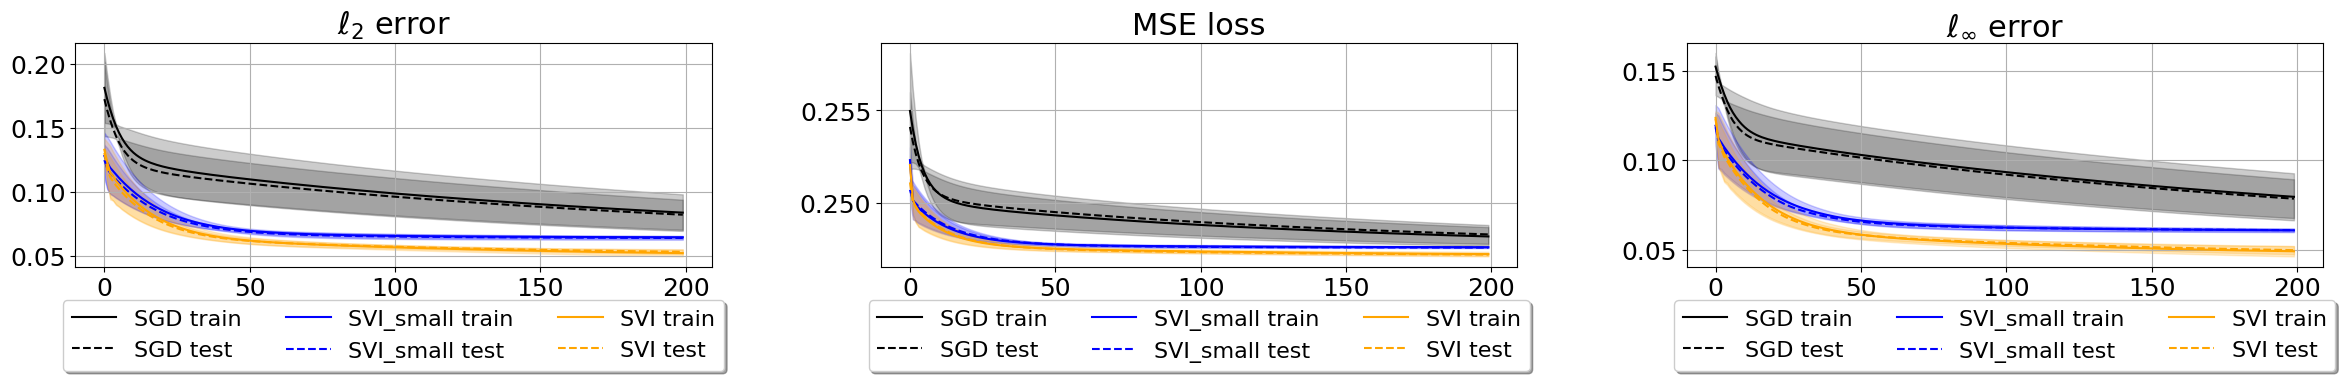

In [28]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = epochs
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD test MSE loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test MSE loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test MSE loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD test l2 error mean: {ave_results_SGD["pred_l2_test_loss"][stop-1]} +/- {ave_results_SGD["pred_l2_test_loss_std"][stop-1]}')
print(f'SVI_old test l2 error mean: {ave_results_SVI_old["pred_l2_test_loss"][stop-1]} +/- {ave_results_SVI_old["pred_l2_test_loss_std"][stop-1]}')
print(f'SVI test l2 error mean: {ave_results_SVI_new["pred_l2_test_loss"][stop-1]} +/- {ave_results_SVI_new["pred_l2_test_loss_std"][stop-1]}')
print('####################')
print(f'SGD test linf error mean: {ave_results_SGD["pred_linf_test_loss"][stop-1]} +/- {ave_results_SGD["pred_linf_test_loss_std"][stop-1]}')
print(f'SVI_old test linf error mean: {ave_results_SVI_old["pred_linf_test_loss"][stop-1]} +/- {ave_results_SVI_old["pred_linf_test_loss_std"][stop-1]}')
print(f'SVI test linf error mean: {ave_results_SVI_new["pred_linf_test_loss"][stop-1]} +/- {ave_results_SVI_new["pred_linf_test_loss_std"][stop-1]}')

fig, ax = plt.subplots(1, 3, figsize=(24, 4))
fsize = 22
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}

args = {'ax': ax[0]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'pred_l2_train_loss', 'pred_l2_test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title(r'$\ell_2$ error', fontsize=fsize)


args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('MSE loss', fontsize=fsize)


args = {'ax': ax[2]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'pred_linf_train_loss', 'pred_linf_test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[2].set_title(r'$\ell_{\infty}$ error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

/tmp/ipykernel_94/4005357527.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
/tmp/ipykernel_94/4005357527.py:66: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax2.get_shared_x_axes().join(temp_fig, ax2)
/tmp/ipykernel_94/4005357527.py:67: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax2.get_shared_y_axes().join(temp_fig, ax2)


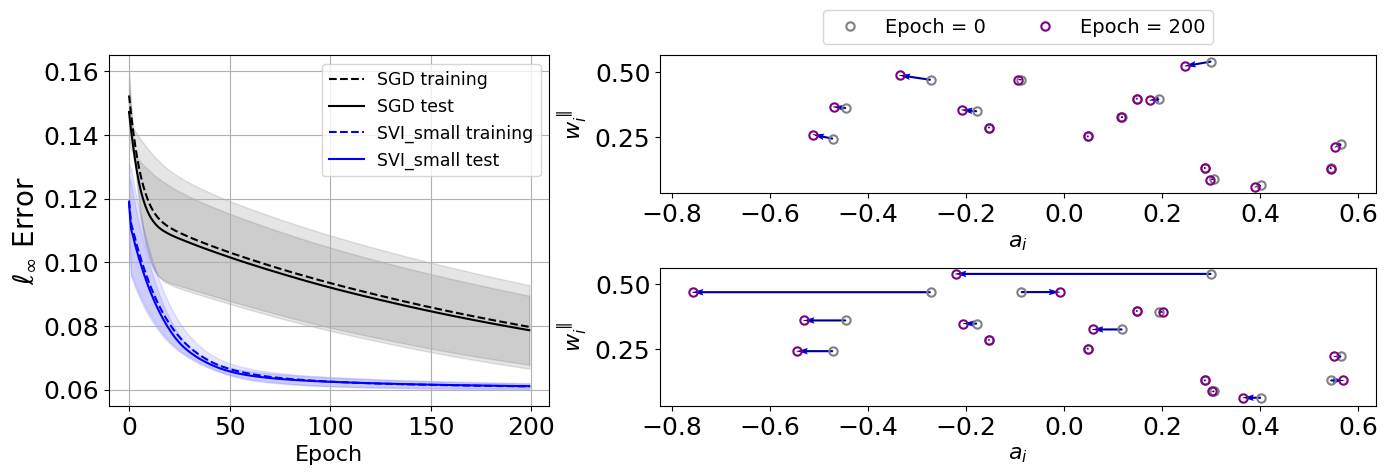

In [29]:
key = 'convs.1.lin.weight' if nlayers > 2 else 'convs.0.lin.weight'
SGD_dict_final = results_final_dict_SGD[random_states[-1]]['model']
SVI_dict = results_final_dict_SVI_old # Old or new SVI
SVI_dict_ave = ave_results_SVI_old # Old or new SVI
VI_dict_final = SVI_dict[random_states[-1]]['model']

w_ref = SGD_dict_ref[key].cpu().detach().numpy()
w_SGD = SGD_dict_final[key].cpu().detach().numpy()
w_VI = VI_dict_final[key].cpu().detach().numpy()
w_ref_inner = np.sum(w_ref*w_ref, axis=1)
w_SGD_final = np.sum(w_ref*w_SGD, axis=1)
w_VI_final = np.sum(w_ref*w_VI, axis=1)
key2 = 'convs.2.lin.weight' if nlayers > 2 else 'convs.1.lin.weight'
a_SGD_ref = SGD_dict_ref[key2].cpu().detach().numpy().flatten()
a_VI_ref = VI_dict_ref_old[key2].cpu().detach().numpy().flatten()
a_SGD_final = SGD_dict_final[key2].cpu().detach().numpy().flatten()
a_VI_final = VI_dict_final[key2].cpu().detach().numpy().flatten()
a_SGD = [a_SGD_ref, a_SGD_final]
a_VI = [a_VI_ref, a_VI_final]
w_SGD = [w_ref_inner, w_SGD_final]
w_VI = [w_ref_inner, w_VI_final]
linferror_ls_SGD = [ave_results_SGD['pred_linf_train_loss'], ave_results_SGD['pred_linf_train_loss_std'], 
                    ave_results_SGD['pred_linf_test_loss'], ave_results_SGD['pred_linf_test_loss_std']]
linferror_ls_SVI = [SVI_dict_ave['pred_linf_train_loss'], SVI_dict_ave['pred_linf_train_loss_std'], 
                    SVI_dict_ave['pred_linf_test_loss'], SVI_dict_ave['pred_linf_test_loss_std']]
plot_dynamics(a_SGD, w_SGD, a_VI, w_VI, linferror_ls_SGD, linferror_ls_SVI, mult = 1)

## Three layer (for neuron dynamic plot)

NOTE: if we want to reproduce EXACTLY the table, we need to follow line 285 onward in `simulation_GNN.py`

In [21]:
# Hyperparameters
random_states = [1103, 1111, 1214] # This coupled with `Variable` for SGD would get the same results as in paper
H = 16
nlayers = 3
graph_type = 'small'
perturb_edge = False
splus = False # If use softplus activation in estimation (true model ALWAYS relu)
N = 2000  # Num training data
N1 = 2000  # Num test data
batch_size = int(N/20)

learning_rate = 0.001
momen = 0.99
epochs = 200

save = True
import pickle
edge_pert = 'perturb' if perturb_edge else 'no_perturb'
savename = f'GCN_recovery_{nlayers}_layers_results_{graph_type}_graph_{H}_{edge_pert}.pkl'

### Training

In [21]:
# random_states = [1103]
# epochs = 10

In [22]:
# SGD
results_final_dict_SGD, SGD_dict_ref, model_SGD = all_together(random_states, SGD = True, nlayers = nlayers)

No edge perturbation
True Prob is [[0.39282212]
 [0.95261896]
 [0.4003304 ]
 [0.38874537]
 [0.9819635 ]]
True Prob is [[0.7376542]
 [0.9804112]
 [0.8484274]
 [0.8074113]
 [0.9944443]]
SGD , H=16, random_state=1103
training loss = 1.41e-01, test loss = 1.41e-01
training l2 error = 9.34e-02, test l2 error = 9.53e-02
training linf error = 1.19e-01, test linf error = 1.23e-01
No edge perturbation
True Prob is [[0.85005164]
 [0.39282212]
 [0.8139463 ]
 [0.92577314]
 [0.3743382 ]]
True Prob is [[0.39282212]
 [0.39282212]
 [0.7858349 ]
 [0.39966273]
 [0.39492133]]
SGD , H=16, random_state=1111
training loss = 1.40e-01, test loss = 1.40e-01
training l2 error = 8.23e-02, test l2 error = 8.48e-02
training linf error = 1.04e-01, test linf error = 1.09e-01
No edge perturbation
True Prob is [[0.8871644 ]
 [0.39282212]
 [0.92324555]
 [0.93887997]
 [0.40099397]]
True Prob is [[0.39282212]
 [0.8836546 ]
 [0.39282212]
 [0.40132105]
 [0.9436527 ]]
SGD , H=16, random_state=1214
training loss = 1.41e-01, 

In [23]:
# SVI old small scale
results_final_dict_SVI_old, VI_dict_ref_old, model_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True, nlayers = nlayers)

No edge perturbation
True Prob is [[0.39282212]
 [0.95261896]
 [0.4003304 ]
 [0.38874537]
 [0.9819635 ]]
True Prob is [[0.7376542]
 [0.9804112]
 [0.8484274]
 [0.8074113]
 [0.9944443]]
SVI old, H=16, random_state=1103
training loss = 1.38e-01, test loss = 1.38e-01
training l2 error = 6.01e-02, test l2 error = 6.23e-02
training linf error = 9.58e-02, test linf error = 1.00e-01
No edge perturbation
True Prob is [[0.85005164]
 [0.39282212]
 [0.8139463 ]
 [0.92577314]
 [0.3743382 ]]
True Prob is [[0.39282212]
 [0.39282212]
 [0.7858349 ]
 [0.39966273]
 [0.39492133]]
SVI old, H=16, random_state=1111
training loss = 1.38e-01, test loss = 1.38e-01
training l2 error = 5.57e-02, test l2 error = 5.46e-02
training linf error = 8.96e-02, test linf error = 8.56e-02
No edge perturbation
True Prob is [[0.8871644 ]
 [0.39282212]
 [0.92324555]
 [0.93887997]
 [0.40099397]]
True Prob is [[0.39282212]
 [0.8836546 ]
 [0.39282212]
 [0.40132105]
 [0.9436527 ]]
SVI old, H=16, random_state=1214
training loss = 1

In [24]:
# SVI new original scale
results_final_dict_SVI_new, VI_dict_ref, model_SVI = all_together(random_states, SGD = False,
                                          small_prev_layer = False, nlayers = nlayers)

No edge perturbation
True Prob is [[0.39282212]
 [0.95261896]
 [0.4003304 ]
 [0.38874537]
 [0.9819635 ]]
True Prob is [[0.7376542]
 [0.9804112]
 [0.8484274]
 [0.8074113]
 [0.9944443]]
SVI new, H=16, random_state=1103
training loss = 1.37e-01, test loss = 1.37e-01
training l2 error = 2.70e-02, test l2 error = 2.63e-02
training linf error = 4.51e-02, test linf error = 4.48e-02
No edge perturbation
True Prob is [[0.85005164]
 [0.39282212]
 [0.8139463 ]
 [0.92577314]
 [0.3743382 ]]
True Prob is [[0.39282212]
 [0.39282212]
 [0.7858349 ]
 [0.39966273]
 [0.39492133]]
SVI new, H=16, random_state=1111
training loss = 1.37e-01, test loss = 1.37e-01
training l2 error = 3.01e-02, test l2 error = 3.08e-02
training linf error = 5.00e-02, test linf error = 5.17e-02
No edge perturbation
True Prob is [[0.8871644 ]
 [0.39282212]
 [0.92324555]
 [0.93887997]
 [0.40099397]]
True Prob is [[0.39282212]
 [0.8836546 ]
 [0.39282212]
 [0.40132105]
 [0.9436527 ]]
SVI new, H=16, random_state=1214
training loss = 1

In [25]:
# Save
if save:
    file_to_save = {'SGD_results': results_final_dict_SGD,'SGD_dict_ref': SGD_dict_ref,
                    'SVI_old_results': results_final_dict_SVI_old,'SVI_old_dict_ref': VI_dict_ref_old,
                    'SVI_new_results': results_final_dict_SVI_new,'SVI_new_dict_ref': VI_dict_ref}
    with open(savename, 'wb') as f:
        pickle.dump(file_to_save, f)

### Eval and visualize

In [22]:
# Save
# Load
load = True
import os
if os.path.exists(savename) and load:
    with open(savename, 'rb') as f:
        file_to_save = pickle.load(f)
    results_final_dict_SGD = file_to_save['SGD_results']
    SGD_dict_ref = file_to_save['SGD_dict_ref']
    results_final_dict_SVI_old = file_to_save['SVI_old_results']
    VI_dict_ref_old = file_to_save['SVI_old_dict_ref']
    results_final_dict_SVI_new = file_to_save['SVI_new_results']
    VI_dict_ref = file_to_save['SVI_new_dict_ref']

H = 16, by epoch 200 out of 200 epochs
####################
SGD test MSE loss mean: 0.140324171880881 +/- 0.0006005764839086268
SVI_old test MSE loss mean: 0.138264861702919 +/- 0.0005762672658736577
SVI test MSE loss mean: 0.13656378388404847 +/- 8.506829219967965e-05
####################
SGD test l2 error mean: 0.08879544834295909 +/- 0.004633893848891819
SVI_old test l2 error mean: 0.06324285144607227 +/- 0.007484537377712726
SVI test l2 error mean: 0.029644920180241268 +/- 0.002371864461606803
####################
SGD test linf error mean: 0.11423576871554057 +/- 0.0064789466058119295
SVI_old test linf error mean: 0.0998902643720309 +/- 0.011564174942284986
SVI test linf error mean: 0.04990942155321439 +/- 0.003694703927191139


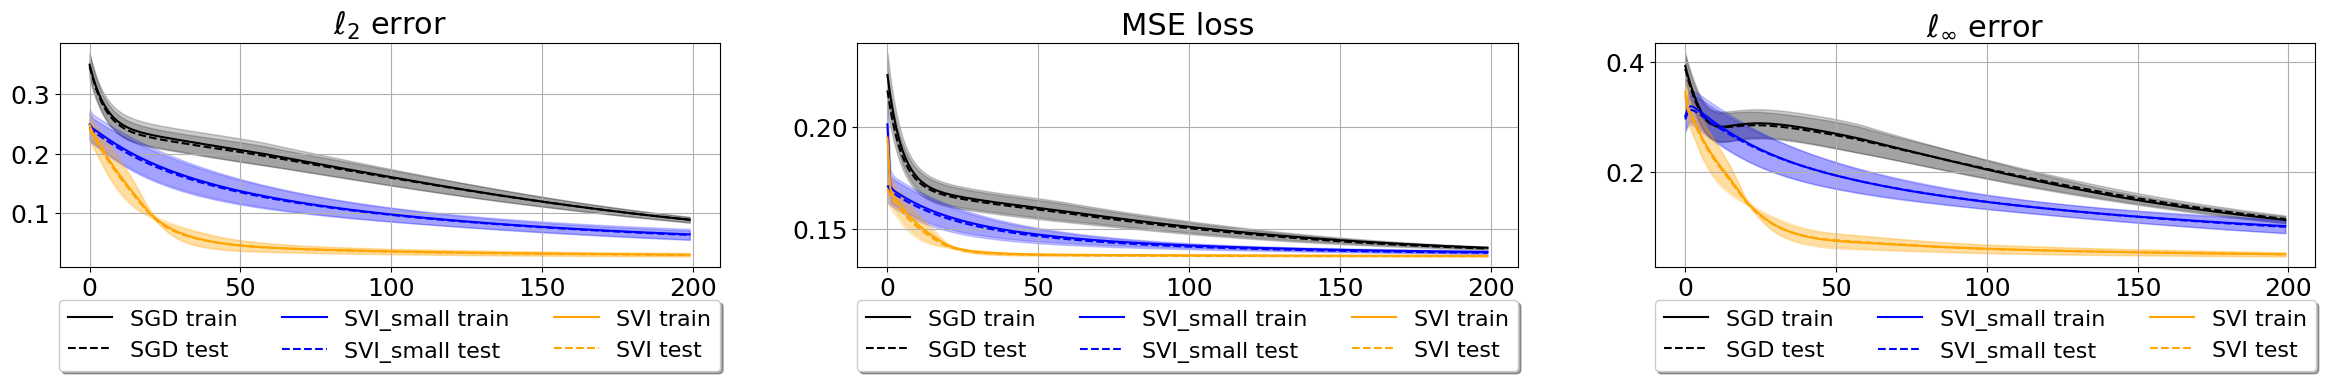

In [23]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = epochs
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD test MSE loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test MSE loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test MSE loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD test l2 error mean: {ave_results_SGD["pred_l2_test_loss"][stop-1]} +/- {ave_results_SGD["pred_l2_test_loss_std"][stop-1]}')
print(f'SVI_old test l2 error mean: {ave_results_SVI_old["pred_l2_test_loss"][stop-1]} +/- {ave_results_SVI_old["pred_l2_test_loss_std"][stop-1]}')
print(f'SVI test l2 error mean: {ave_results_SVI_new["pred_l2_test_loss"][stop-1]} +/- {ave_results_SVI_new["pred_l2_test_loss_std"][stop-1]}')
print('####################')
print(f'SGD test linf error mean: {ave_results_SGD["pred_linf_test_loss"][stop-1]} +/- {ave_results_SGD["pred_linf_test_loss_std"][stop-1]}')
print(f'SVI_old test linf error mean: {ave_results_SVI_old["pred_linf_test_loss"][stop-1]} +/- {ave_results_SVI_old["pred_linf_test_loss_std"][stop-1]}')
print(f'SVI test linf error mean: {ave_results_SVI_new["pred_linf_test_loss"][stop-1]} +/- {ave_results_SVI_new["pred_linf_test_loss_std"][stop-1]}')

fig, ax = plt.subplots(1, 3, figsize=(24, 4))
fsize = 22
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}

args = {'ax': ax[0]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'pred_l2_train_loss', 'pred_l2_test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title(r'$\ell_2$ error', fontsize=fsize)


args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('MSE loss', fontsize=fsize)


args = {'ax': ax[2]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'pred_linf_train_loss', 'pred_linf_test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[2].set_title(r'$\ell_{\infty}$ error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

/tmp/ipykernel_94/4005357527.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
/tmp/ipykernel_94/4005357527.py:66: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax2.get_shared_x_axes().join(temp_fig, ax2)
/tmp/ipykernel_94/4005357527.py:67: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax2.get_shared_y_axes().join(temp_fig, ax2)


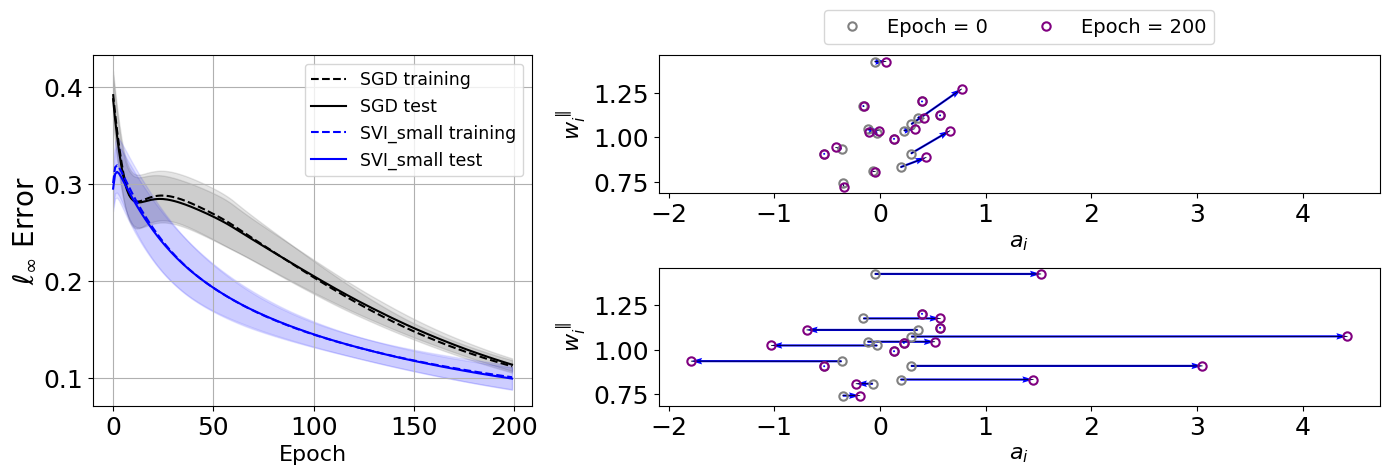

In [25]:
key = 'convs.1.lin.weight' if nlayers > 2 else 'convs.0.lin.weight'
SGD_dict_final = results_final_dict_SGD[random_states[-1]]['model']
SVI_dict = results_final_dict_SVI_old # Old or new SVI
SVI_dict_ave = ave_results_SVI_old # Old or new SVI
VI_dict_final = SVI_dict[random_states[-1]]['model']

w_ref = SGD_dict_ref[key].cpu().detach().numpy()
w_SGD = SGD_dict_final[key].cpu().detach().numpy()
w_VI = VI_dict_final[key].cpu().detach().numpy()
w_ref_inner = np.sum(w_ref*w_ref, axis=1)
w_SGD_final = np.sum(w_ref*w_SGD, axis=1)
w_VI_final = np.sum(w_ref*w_VI, axis=1)
key2 = 'convs.2.lin.weight' if nlayers > 2 else 'convs.1.lin.weight'
a_SGD_ref = SGD_dict_ref[key2].cpu().detach().numpy().flatten()
a_VI_ref = VI_dict_ref_old[key2].cpu().detach().numpy().flatten()
a_SGD_final = SGD_dict_final[key2].cpu().detach().numpy().flatten()
a_VI_final = VI_dict_final[key2].cpu().detach().numpy().flatten()
a_SGD = [a_SGD_ref, a_SGD_final]
a_VI = [a_VI_ref, a_VI_final]
w_SGD = [w_ref_inner, w_SGD_final]
w_VI = [w_ref_inner, w_VI_final]
linferror_ls_SGD = [ave_results_SGD['pred_linf_train_loss'], ave_results_SGD['pred_linf_train_loss_std'], 
                    ave_results_SGD['pred_linf_test_loss'], ave_results_SGD['pred_linf_test_loss_std']]
linferror_ls_SVI = [SVI_dict_ave['pred_linf_train_loss'], SVI_dict_ave['pred_linf_train_loss_std'], 
                    SVI_dict_ave['pred_linf_test_loss'], SVI_dict_ave['pred_linf_test_loss_std']]
plot_dynamics(a_SGD, w_SGD, a_VI, w_VI, linferror_ls_SGD, linferror_ls_SVI, mult = 1)